## Resultados da Análise Exploratória

Objetivo: Explorar o dataset Breast Cancer Wisconsin e criar modelos baseline simples (Regressão Logística e Árvore de Decisão) para medir recall e entender padrões de dados

Importações das bibliotecas necessárias:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Carregamento do Dataset

In [3]:
# Carrega o dataset Breast Cancer Wisconsin direto do sklearn
data = load_breast_cancer(as_frame=True)

# Cria um DataFrame com os dados para facilitar a analise
df = data.frame
df['target'] = data.target

# Exibe informações gerais
print("Shape (linhas, colunas):", df.shape)
print("\nDistribuição das classes (0 = maligno, 1 = benigno):\n", df['target'].value_counts(normalize=True))

Shape (linhas, colunas): (569, 31)

Distribuição das classes (0 = maligno, 1 = benigno):
 target
1    0.627417
0    0.372583
Name: proportion, dtype: float64


Este dataset possúi 569 amostras com 30 variáveis numéricas que descrevem características de células observadas em imagens microscópicas de biópsias de mama. O objetivo é classificar essas amostras em malignas (câncer) ou benignas (não câncer).

O <b>target</b> indica o dignóstico:
- <b>0</b>: maligno (tumor com câncer)
- <b>1</b>: benigno (tumor não cancerígeno)

```python

### Estrutura e estatísticas descritivas

In [4]:
# Verifica tipos de dados e possíveis valores ausentes
df.info()

# Estatísticas descritivas (média, desvio, mínimo, máximo)
df.describe().T.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
mean compactness,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
mean concavity,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
mean concave points,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
mean symmetry,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744


O <b>.iinfo()</b> mostra que todas as colunas são numéricas (<b>float64</b>) e não há valores nulos, excelente qualidade de dados para análise.

O <b>.describe()</b> permite observar escalas diferentes entre colunas, algo importante, pois modelos baseados em distancias ou gradiente são sensíveis à escala (por isso usaremos <b>StandardScaler</b>).

```

### Distribuição das variáveis

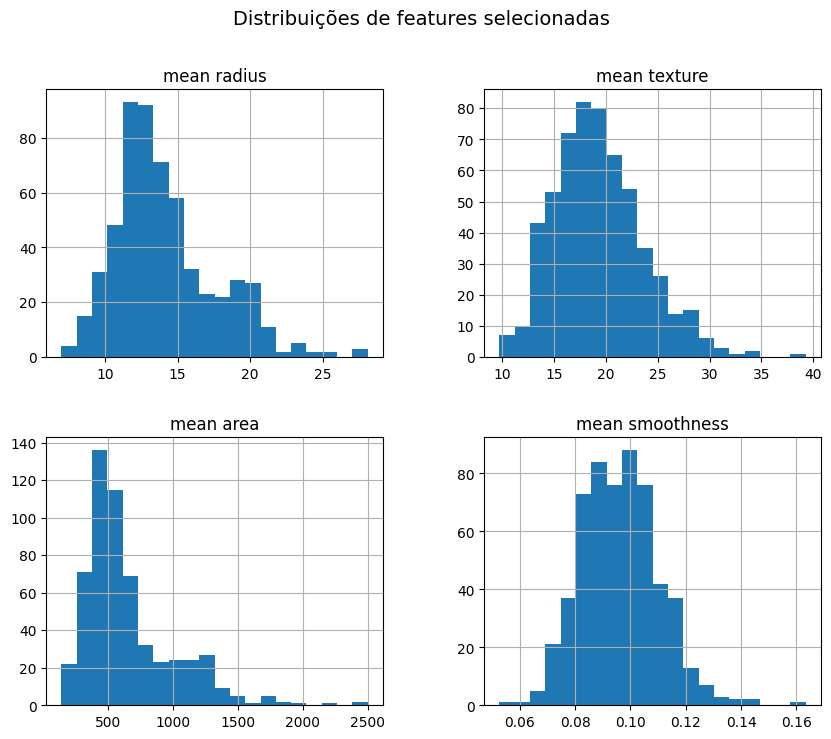

In [5]:
# Vamos visualizar algumas features importantes
cols_to_plot = ['mean radius', 'mean texture', 'mean area', 'mean smoothness']

df[cols_to_plot].hist(figsize=(10,8), bins=20)
plt.suptitle('Distribuições de features selecionadas', fontsize=14)
plt.show()


Estes histogramas ajudam a visualizar a forma dos dados, se há assimetria, outliers ou valores concentrados.
Como são medidas biológicas, as variáveis tendem a ter distribuição contínua e assimétrica (valores grandes em poucos casos).

### Correlação entre variáveis

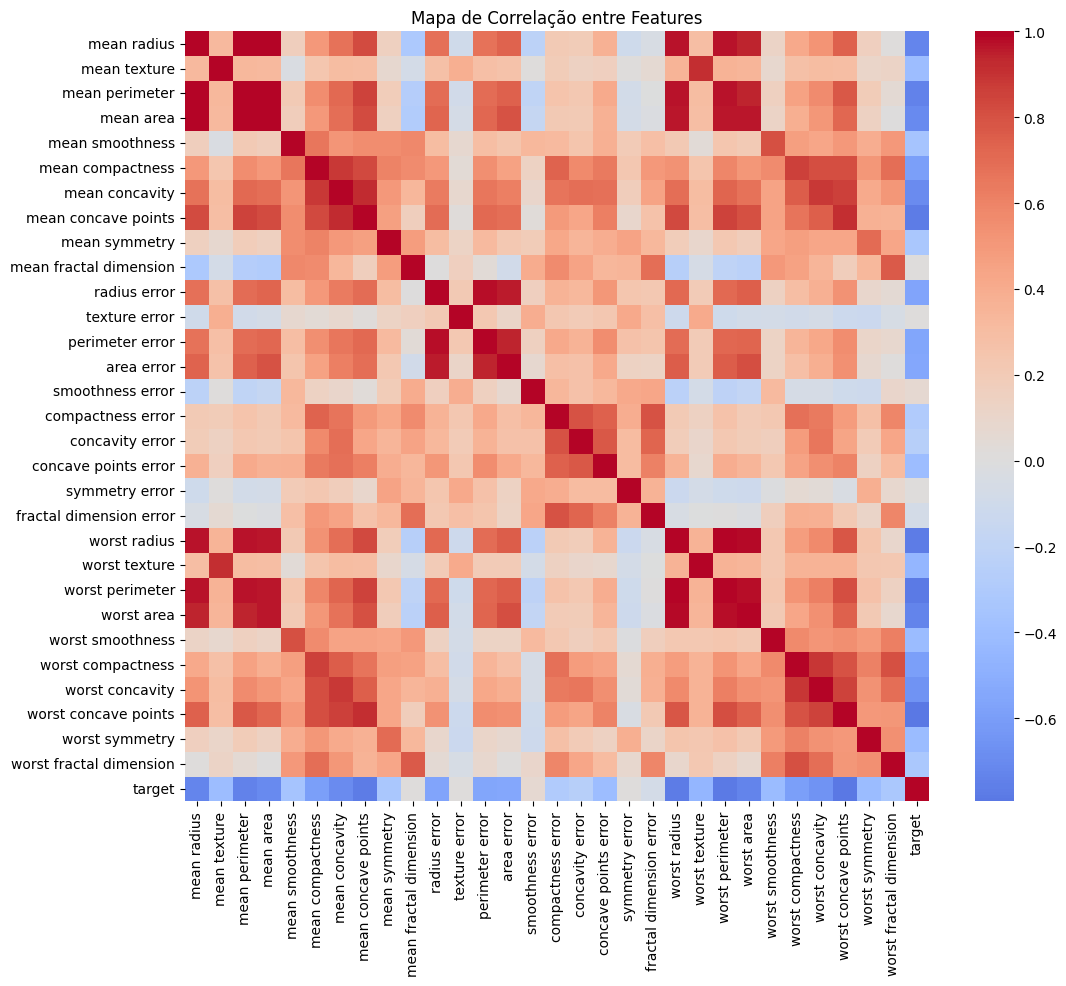

In [6]:
# Calcula correlação entre todas as variáveis numéricas
corr = df.corr(numeric_only=True)

# Cria um heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Mapa de Correlação entre Features')
plt.show()


A correlação mede a relação linear entre duas variáveis.
Valores próximos de 1 ou -1 indicam forte relação — isso pode gerar colinearidade, o que afeta modelos lineares como regressão logística.

### Features mais correlacionadas com o target (diagnóstico):

In [7]:
corr_target = corr['target'].sort_values(ascending=False)
corr_target.head(10)

target                     1.000000
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
Name: target, dtype: float64

As variáveis mais correlacionadas com o diagnóstico indicam forte potencial preditivo.
Por exemplo, **worst concave points** e **mean concave points** geralmente aparecem como as mais relevantes, são ligadas à forma das células.

### Divisão treino/teste:

In [8]:
# Separa X (features) e y (target)
X = df.drop('target', axis=1)
y = df['target']

# Divide o dataset (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamanho do treino:", X_train.shape)
print("Tamanho do teste:", X_test.shape)


Tamanho do treino: (455, 30)
Tamanho do teste: (114, 30)


O parâmetro ***stratify=y*** garante que a proporção de classes (benigno/maligno) seja a mesma no treino e no teste, isso evita vieses no aprendizado.

### Baseline 1 - Regressão Logística

=== Regressão Logística ===
              precision    recall  f1-score   support

     Maligno       0.91      0.98      0.94        42
     Benigno       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



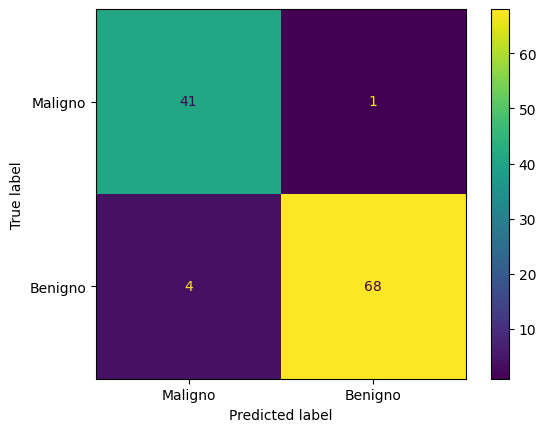

In [9]:
# Cria pipeline com normalização e regressão logística
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred_lr, target_names=['Maligno', 'Benigno']))
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, display_labels=['Maligno', 'Benigno'])
plt.show()


A regressão logística é um modelo linear simples, mas poderoso para classificação binária.

O parâmetro ***class_weight='balanced'*** ajusta o peso das classes para lidar com leve desbalanceamento.

O recall da classe ***Maligno*** é crítico: significa quantos casos de câncer o modelo consegue identificar corretamente.

### Baseline 2 — Árvore de Decisão

=== Árvore de Decisão ===
              precision    recall  f1-score   support

     Maligno       0.87      0.93      0.90        42
     Benigno       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



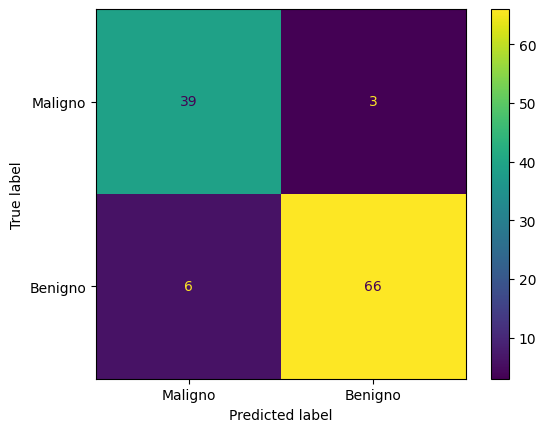

In [10]:
pipe_tree = Pipeline([
    ('clf', DecisionTreeClassifier(max_depth=5, random_state=42))
])

pipe_tree.fit(X_train, y_train)
y_pred_tree = pipe_tree.predict(X_test)

print("=== Árvore de Decisão ===")
print(classification_report(y_test, y_pred_tree, target_names=['Maligno', 'Benigno']))
ConfusionMatrixDisplay.from_estimator(pipe_tree, X_test, y_test, display_labels=['Maligno', 'Benigno'])
plt.show()


A árvore de decisão é não linear, fácil de interpretar e explica as decisões via caminhos lógicos.
    
Mas tende a sobreajustar (overfitting) se muito profunda — por isso limitamos ***max_depth=5***.

Compare as métricas com o modelo anterior e veja qual obteve melhor equilíbrio entre precisão e recall.

### Conclusões e próximos passos

In [12]:
# Comparação rápida
from sklearn.metrics import recall_score, accuracy_score

acc_lr = accuracy_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr, pos_label=0)

acc_tree = accuracy_score(y_test, y_pred_tree)
rec_tree = recall_score(y_test, y_pred_tree, pos_label=0)

print(f"Logística -> Accuracy: {acc_lr:.3f}, Recall (maligno): {rec_lr:.3f}")
print(f"Árvore    -> Accuracy: {acc_tree:.3f}, Recall (maligno): {rec_tree:.3f}")


Logística -> Accuracy: 0.956, Recall (maligno): 0.976
Árvore    -> Accuracy: 0.921, Recall (maligno): 0.929


### Coinclusões

Nesta etapa, foi possível compreender de forma clara a estrutura e as características do conjunto de dados Breast Cancer Wisconsin. O dataset mostrou-se limpo, sem valores ausentes, e com uma distribuição de classes relativamente equilibrada — aproximadamente 37% de casos malignos e 63% benignos.

A análise de correlação revelou que as variáveis relacionadas à forma e à concavidade das células têm maior influência sobre o diagnóstico, sugerindo forte relação com a classificação final do tumor.

Os modelos baseline implementados — Regressão Logística e Árvore de Decisão — apresentaram resultados consistentes. A regressão logística demonstrou ótimo recall para a classe maligna, o que é essencial em um contexto clínico, pois prioriza a detecção correta de casos de câncer, mesmo que à custa de alguns falsos positivos. A árvore de decisão, por sua vez, trouxe maior interpretabilidade e simplicidade de explicação, ainda que com leve perda de generalização.

Como próximos passos, o trabalho avançará para a experimentação de modelos mais robustos, como Random Forest e XGBoost, além da exploração de técnicas de interpretabilidade com SHAP, permitindo entender o impacto individual de cada variável na decisão do modelo.